# Image to solution

## Overview

This notebook takes a screenshot of a KenKen puzzle from http://www.kenkenpuzzle.com/game as input, and outputs the solution in the form of a list of lists.

The key addition of this notebook to the codebase is that it automates code generation for constraints. Previously this was done manually, and is extremely error prone and tedious.

## How it works

The algorithm works as follows:

1. threshold the image to remove a highlighted square if one is present
2. crop the white borders surrounding the grid
3. figure out the width of the top border, and scan a horizontal line just below to figure out the puzzle dimensions
4. scan horizontal lines to classify the right borders of each cell as boundary or not boundary, and vertical lines for the bottom borders
5. find boundary groups, and find the arithmetic constraints for each boundary group
    1. finding boundary groups is done recursively using 4.
    2. arithmetic constraints are found with [pytesseract](https://pypi.org/project/pytesseract/)
        1. the rightmost black blob is located and separated from the remaining left black blobs
        2. if no left black blobs exist, the right black blob is a fixed numeric constraint (i.e. cell equals 7)
        3. else the rightmost black blob is classified as an arithmetic symbol, and the left blobs an integer
6. build the generic puzzle constraints with [Z3](https://github.com/Z3Prover/z3)
7. add the arithmetic constraints for each boundary
8. solve and output solution

## Thoughts on usage

Since the finding of arithmetic constraints for each boundary group can be a little buggy, I think this code is best used in notebook form, to give the user the opportunity to double check the arithmetic constraints and modify any mistakes they see.

## How to improve

- pytesseract can be buggy with symbols, i.e. not recognizing minus, resulting in division
  - would be nice to write a custom symbol classifier. could probably get away with it myself as there are only four

In [95]:
import cv2 as cv

In [96]:
from matplotlib import pyplot as plt

## Input path to image

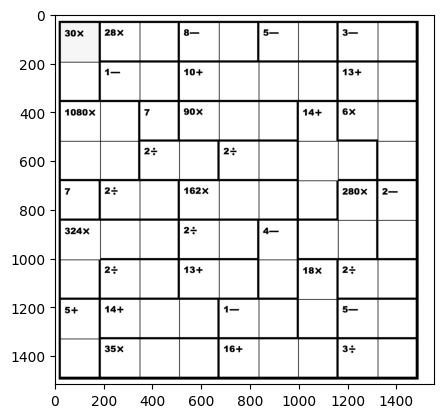

In [150]:
img = cv.imread("../imgs/74592.png", cv.IMREAD_GRAYSCALE)
plt.imshow(img, cmap="gray")

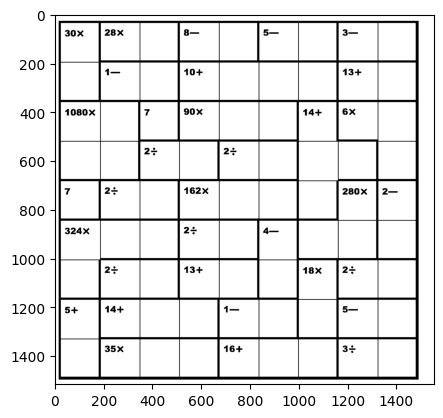

In [151]:
# step 1: remove highlighted square

ret, thresh = cv.threshold(img,127,255,cv.THRESH_BINARY)
plt.imshow(thresh, cmap="gray")

In [152]:
# step 2: crop image to perfectly fit borders
# go down from top middle width for top edge until value is black (0), and note y axis. same logic for other edges

# [0]: rows, [1]: cols
img_dimensions = thresh.shape
crop_top = 0
crop_bot = 0
crop_lef = 0
crop_rig = 0

# find crop_top
for i in range(img_dimensions[0]):
    if thresh[i][img_dimensions[1]//2] == 0:
        crop_top = i
        break
        
# find crop_bot
for i in range(img_dimensions[0]-1, 0, -1):
    if thresh[i][img_dimensions[1]//2] == 0:
        crop_bot = i
        break
        
# find crop_lef
for i in range(img_dimensions[1]):
    if thresh[img_dimensions[0]//2][i] == 0:
        crop_lef = i
        break
        
# find crop_rig
for i in range(img_dimensions[1]-1, 0, -1):
    if thresh[img_dimensions[0]//2][i] == 0:
        crop_rig = i
        break

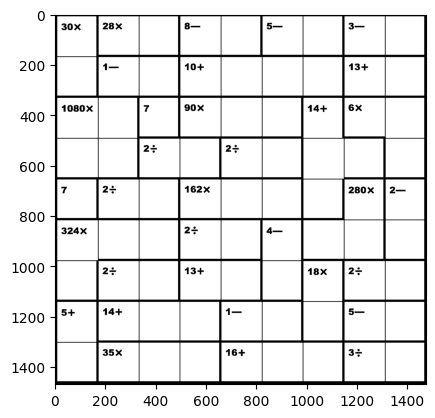

In [153]:
cropped = thresh[crop_top:crop_bot, crop_lef:crop_rig]
plt.imshow(cropped, cmap="gray")

In [154]:
# step 3: scan one horizontal line from the top left white pixel to find puzzle dimensions (i.e. 4x4)
# top_left_white is found by walking diagonally down from the top left corner until non-black is hit

# find end of top black line
img_dimensions = cropped.shape

top_left_white = 0
for i in range(img_dimensions[0]):
    if cropped[i][i] != 0:
        top_left_white = i
        break

In [155]:
top_left_white

9

In [156]:
pixels_in_boundary = top_left_white

In [204]:
# test
cropped_copy = cropped.copy()
plt.imshow(cv.line(cropped_copy, (0, top_left_white), (img_dimensions[0]//2, top_left_white), (127, 127, 127), 5), cmap="gray")

In [158]:
count_num_white_chunks = 1
cur_white = True
for i in range(top_left_white, img_dimensions[0]):
    if cur_white and cropped[top_left_white][i] == 0:
        cur_white = False
    if not cur_white and cropped[top_left_white][i] == 255:
        count_num_white_chunks += 1
        cur_white = True

In [159]:
count_num_white_chunks

9

In [160]:
puzzle_dimensions = count_num_white_chunks

In [161]:
# step 4: scan horizontal lines and vertical lines to find constraint boundaries
# step 5: scan top left of each boundary for boundary numeric constraint

# bounds_right and bounds_down will be of the form [[boolean for _ in range(puzzle_dimensions-1)] for _ in range(puzzle_dimensions)]
bounds_right = []
bounds_down = []

# horizontal lines for bounds_right discovery
for line in range(puzzle_dimensions):
    # add bonus small amount for robustness
    row = (line * img_dimensions[0]//puzzle_dimensions) + pixels_in_boundary + 5
    cur_white = True
    first_black = None
    row_bounds_right = []
    for i in range(pixels_in_boundary, img_dimensions[1]-pixels_in_boundary):
        cur_pixel = cropped[row][i]
        if cur_white and cur_pixel == 0:
            cur_white = False
            first_black = i
        if not cur_white and cur_pixel == 255:
            row_bounds_right.append(i-first_black == pixels_in_boundary)
            cur_white = True
    bounds_right.append(row_bounds_right)

# vertical lines for bounds_down discovery
for line in range(puzzle_dimensions):
    # add bonus small amount for robustness
    col = (line * img_dimensions[1]//puzzle_dimensions) + pixels_in_boundary + 5
    cur_white = True
    first_black = None
    row_bounds_down = []
    for i in range(pixels_in_boundary, img_dimensions[0]-pixels_in_boundary):
        cur_pixel = cropped[i][col]
        if cur_white and cur_pixel == 0:
            cur_white = False
            first_black = i
        if not cur_white and cur_pixel == 255:
            row_bounds_down.append(i-first_black == pixels_in_boundary)
            cur_white = True
    bounds_down.append(row_bounds_down)

In [162]:
bounds_right

[[True, False, True, False, True, False, True, False],
 [True, False, True, False, False, False, True, False],
 [False, True, True, False, False, True, True, False],
 [False, True, False, True, False, True, False, True],
 [True, False, True, False, False, True, True, True],
 [False, False, True, False, True, True, False, True],
 [True, False, True, False, True, True, True, False],
 [True, False, False, True, False, True, True, False],
 [True, False, False, True, False, False, True, False]]

In [163]:
bounds_down

[[False, True, False, True, True, False, True, False],
 [True, True, False, True, True, True, True, True],
 [True, True, True, True, True, True, True, True],
 [True, True, True, True, True, True, True, True],
 [True, True, True, True, True, True, True, True],
 [True, True, True, True, True, False, True, True],
 [True, True, False, False, True, True, False, True],
 [True, True, True, True, False, True, True, True],
 [True, True, False, True, False, True, True, True]]

In [164]:
def find_rightmost_black(img, starting_col):
    """
    Return col value of rightmost black pixel
    """
    for col in range(starting_col, 0, -1):
        # TODO understand why sometimes this crashes without the -1 in img.shape[0]-1
        for row in range(img.shape[0]-1):
            if img[row][col] == 0:
                return col

def find_leftmost_black(img):
    """
    Return col value of leftmost column that does not contain a black pixel, starting with the leftmost column
    
    To be used after find_rightmost_black to isolate a + or ÷ symbol
    """
    for col in range(img.shape[1]-1, 0, -1):
        found_black = False
        for row in range(img.shape[0]):
            if img[row][col] == 0:
                found_black = True
                break
        if not found_black:
            return col
        
def img_contains_black(img):
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            if img[row][col] == 0:
                return True
    return False

In [194]:
# assign each cell to a boundary number
cell_boundary_numbers = [[-1 for _ in range(puzzle_dimensions)] for _ in range(puzzle_dimensions)]
boundary_number_to_constraint = {}

def find_cell_missing_boundary(cell_boundary_numbers):
    """
    Returns tuple of index of first cell missing a boundary (has value -1)
    
    If none exist, returns (-1, -1)
    """
    for row in range(len(cell_boundary_numbers)):
        for col in range(len(cell_boundary_numbers)):
            if cell_boundary_numbers[row][col] == -1:
                return (row, col)

    return (-1, -1)


def find_cell_boundary_constraint(img, puzzle_dimensions, pixels_in_boundary, cell):
    """
    Returns (number, operation) for a given cell
    
    Splits up the cell into an image of the number and symbol for string extraction, to prevent cases such as 1- being interpreted as 4
    """
    # step 5: scan top left of each boundary for boundary numeric constraint
    # extract number from image: https://stackoverflow.com/questions/65832561/python-extract-number-from-simple-image
    
    from pytesseract import image_to_string
    
    lef = (cell[1] * img_dimensions[1]//puzzle_dimensions) + pixels_in_boundary
    rig = ((cell[1]+1) * img_dimensions[1]//puzzle_dimensions) - pixels_in_boundary
    top = (cell[0] * img_dimensions[0]//puzzle_dimensions) + pixels_in_boundary
    bot = ((cell[0]+1) * img_dimensions[0]//puzzle_dimensions) - pixels_in_boundary

    cell_img = img[top:bot, lef:rig]
    
    # only need top half
    top_half = cell_img[:cell_img.shape[0]//2, :]
    
    rightmost_black = find_rightmost_black(top_half, top_half.shape[1]-pixels_in_boundary)
    leftmost_black = find_leftmost_black(top_half[:, :rightmost_black])
    
    string_number = ''
    string_symbol = ''
    
    # small additions and subtractions help with error in isolating mistakenly included black borders, and adding surrounding white
    isolated_leftmost_blacks = top_half[:, 1:leftmost_black]
    isolated_rightmost_black = top_half[:, leftmost_black-1:rightmost_black+3]
    
    # check for presence of black to the left of the rightmost blob to eliminate case of cell value being fixed at a number
    has_symbol = img_contains_black(top_half[:, :leftmost_black])
    if has_symbol:
        # https://stackoverflow.com/questions/43705481/pytesseract-set-character-whitelist
        string_number = image_to_string(isolated_leftmost_blacks, config="-c tessedit_char_whitelist=0123456789 --psm 7").strip()
        string_symbol = image_to_string(isolated_rightmost_black, config="-c tessedit_char_whitelist=+—x --psm 7").strip()

        # pytesseract fails to recognize ÷ as it was not part of the training data
        string_symbol = '÷' if string_symbol == '' else string_symbol
    else:
        string_number = image_to_string(isolated_rightmost_black, config="-c tessedit_char_whitelist=0123456789 --psm 7").strip()
        string_symbol = '='

    return (string_number, string_symbol)



def populate_cells_in_boundary(cell_boundary_numbers, cur_cell, cur_boundary_number, bounds_right, bounds_down):
    """
    Recursively write cur_boundary_number to all cell_boundary_numbers for the cells connected to the cur_cell
    """
    row = cur_cell[0]
    col = cur_cell[1]
    
    # base case: check if already visited
    if cell_boundary_numbers[row][col] != -1:
        return

    cell_boundary_numbers[row][col] = cur_boundary_number
    
    # check up
    if row-1 > -1 and not bounds_down[col][row-1]:
        populate_cells_in_boundary(cell_boundary_numbers, (row-1, col), cur_boundary_number, bounds_right, bounds_down)
     
    # check down
    if row+1 < len(cell_boundary_numbers) and not bounds_down[col][row]:
        populate_cells_in_boundary(cell_boundary_numbers, (row+1, col), cur_boundary_number, bounds_right, bounds_down)

    # check left
    if col-1 > -1 and not bounds_right[row][col-1]:
        populate_cells_in_boundary(cell_boundary_numbers, (row, col-1), cur_boundary_number, bounds_right, bounds_down)
       
    # check right
    if col+1 < len(cell_boundary_numbers) and not bounds_right[row][col]:
        populate_cells_in_boundary(cell_boundary_numbers, (row, col+1), cur_boundary_number, bounds_right, bounds_down)
    

cell_missing_boundary = find_cell_missing_boundary(cell_boundary_numbers)
cur_boundary_number = 0
while cell_missing_boundary != (-1, -1):
    boundary_constraint = find_cell_boundary_constraint(cropped, puzzle_dimensions, pixels_in_boundary, cell_missing_boundary)
    boundary_number_to_constraint[cur_boundary_number] = boundary_constraint
    
    populate_cells_in_boundary(cell_boundary_numbers, cell_missing_boundary, cur_boundary_number, bounds_right, bounds_down)
    
    cell_missing_boundary = find_cell_missing_boundary(cell_boundary_numbers)
    cur_boundary_number += 1
    

In [195]:
cell_boundary_numbers

[[0, 1, 1, 2, 2, 3, 3, 4, 4],
 [0, 5, 5, 6, 6, 6, 6, 7, 7],
 [8, 8, 9, 10, 10, 10, 11, 12, 12],
 [8, 8, 13, 13, 14, 14, 11, 11, 12],
 [15, 16, 16, 17, 17, 17, 11, 18, 19],
 [20, 20, 20, 21, 21, 22, 18, 18, 19],
 [20, 23, 23, 24, 24, 22, 25, 26, 26],
 [27, 28, 28, 28, 29, 29, 25, 30, 30],
 [27, 31, 31, 31, 32, 32, 32, 33, 33]]

In [196]:
boundary_number_to_constraint

{0: ('30', 'x'),
 1: ('28', 'x'),
 2: ('8', '—'),
 3: ('5', '—'),
 4: ('3', '—'),
 5: ('1', '—'),
 6: ('10', '+'),
 7: ('13', '+'),
 8: ('1080', 'x'),
 9: ('7', '='),
 10: ('90', 'x'),
 11: ('14', '+'),
 12: ('6', 'x'),
 13: ('2', '÷'),
 14: ('2', '÷'),
 15: ('7', '='),
 16: ('2', '÷'),
 17: ('162', 'x'),
 18: ('280', 'x'),
 19: ('2', '—'),
 20: ('324', 'x'),
 21: ('2', '÷'),
 22: ('4', '—'),
 23: ('2', '÷'),
 24: ('13', '+'),
 25: ('18', 'x'),
 26: ('2', '÷'),
 27: ('5', '+'),
 28: ('14', '+'),
 29: ('1', '—'),
 30: ('5', '—'),
 31: ('35', 'x'),
 32: ('16', '+'),
 33: ('3', '÷')}

In [168]:
# double check and patch constraints if necessary

# boundary_number_to_constraint[5] = ('1', '—')

In [169]:
boundary_number_to_constraint

{0: ('30', 'x'),
 1: ('28', 'x'),
 2: ('8', '—'),
 3: ('5', '—'),
 4: ('3', '—'),
 5: ('1', '—'),
 6: ('10', '+'),
 7: ('13', '+'),
 8: ('1080', 'x'),
 9: ('7', '='),
 10: ('90', 'x'),
 11: ('14', '+'),
 12: ('6', 'x'),
 13: ('2', '÷'),
 14: ('2', '÷'),
 15: ('7', '='),
 16: ('2', '÷'),
 17: ('162', 'x'),
 18: ('280', 'x'),
 19: ('2', '—'),
 20: ('324', 'x'),
 21: ('2', '÷'),
 22: ('4', '—'),
 23: ('2', '÷'),
 24: ('13', '+'),
 25: ('18', 'x'),
 26: ('2', '÷'),
 27: ('5', '+'),
 28: ('14', '+'),
 29: ('1', '—'),
 30: ('5', '—'),
 31: ('35', 'x'),
 32: ('16', '+'),
 33: ('3', '÷')}

In [197]:
# step 6: create generic KenKen constraints
# Python script KenKen code
import z3

from utils.kenken import (division_constraint, minus_constraint,
                          product_constraint, sum_constraint)

# puzzle_dimensions x puzzle_dimensions matrix of integer variables
X = [[z3.Int("x_%s_%s" % (i + 1, j + 1)) for j in range(puzzle_dimensions)] for i in range(puzzle_dimensions)]

# each cell contains a value in {1, ..., puzzle_dimensions}
cells_c = [z3.And(1 <= X[i][j], X[i][j] <= puzzle_dimensions) for i in range(puzzle_dimensions) for j in range(puzzle_dimensions)]

# each row contains a digit at most once
rows_c = [z3.Distinct(X[i]) for i in range(puzzle_dimensions)]

# each column contains a digit at most once
cols_c = [z3.Distinct([X[i][j] for i in range(puzzle_dimensions)]) for j in range(puzzle_dimensions)]

In [198]:
# step 7: add arithmetic boundary constraints
from collections import defaultdict

boundary_number_to_cells = defaultdict(list)

for row in range(puzzle_dimensions):
    for col in range(puzzle_dimensions):
        boundary_number_to_cells[cell_boundary_numbers[row][col]].append(X[row][col])

constraints = []

for boundary_number, constraint in boundary_number_to_constraint.items():
    constraint_number, operator = constraint
    if operator == '+':
        constraints.append([sum_constraint(boundary_number_to_cells[boundary_number], constraint_number)])
    elif '—' in operator: # captures '——', despite pytesseract-set-character-whitelist
        cells = boundary_number_to_cells[boundary_number]
        constraints.append([minus_constraint(cells[0], cells[1], constraint_number)])
    elif operator == 'x':
        constraints.append([product_constraint(boundary_number_to_cells[boundary_number], constraint_number)])
    elif operator == '=':
        constraints.append([z3.And(boundary_number_to_cells[boundary_number][0] == constraint_number)])
    else:
        cells = boundary_number_to_cells[boundary_number]
        constraints.append([division_constraint(cells[0], cells[1], constraint_number)])

In [199]:
# step 8: finish Python script KenKen code and solve!
kenken_c = cells_c + rows_c + cols_c
for constraint in constraints:
    kenken_c += constraint

# initialize with all empty cells
instance = tuple(tuple([0 for _ in range(int(puzzle_dimensions))]) for _ in range(int(puzzle_dimensions)))
instance_c = [
    z3.If(instance[i][j] == 0, True, X[i][j] == instance[i][j])
    for i in range(puzzle_dimensions)
    for j in range(puzzle_dimensions)
]

s = z3.Solver()
s.add(kenken_c + instance_c)
if s.check() == z3.sat:
    m = s.model()
    r = [[m.evaluate(X[i][j]) for j in range(puzzle_dimensions)] for i in range(puzzle_dimensions)]
    z3.print_matrix(r)
else:
    print("failed to solve")

[[6, 7, 4, 1, 9, 3, 8, 5, 2],
 [5, 8, 9, 2, 1, 4, 3, 6, 7],
 [8, 3, 7, 9, 5, 2, 4, 1, 6],
 [9, 5, 8, 4, 3, 6, 7, 2, 1],
 [7, 4, 2, 3, 6, 9, 1, 8, 5],
 [2, 9, 6, 8, 4, 1, 5, 7, 3],
 [3, 2, 1, 6, 7, 5, 9, 4, 8],
 [1, 6, 3, 5, 8, 7, 2, 9, 4],
 [4, 1, 5, 7, 2, 8, 6, 3, 9]]


## Note: experimentation for the above

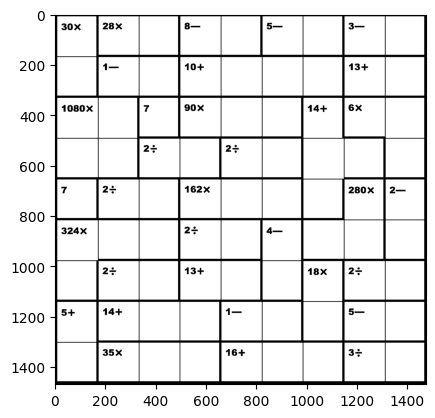

In [171]:
cropped = thresh[crop_top:crop_bot, crop_lef:crop_rig]
plt.imshow(cropped, cmap="gray")

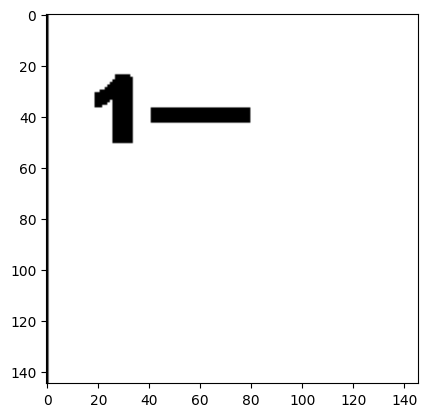

In [172]:
# def find_cell_boundary_constraint(img, puzzle_dimensions, pixels_in_boundary, cell):
img = cropped
cell = (1, 1)

"""
Returns (number, operation) for a given cell

Splits up the cell into an image of the number and symbol for string extraction, to prevent cases such as 1- being interpreted as 4
"""
# step 5: scan top left of each boundary for boundary numeric constraint
# extract number from image: https://stackoverflow.com/questions/65832561/python-extract-number-from-simple-image

from pytesseract import image_to_string

lef = (cell[1] * img_dimensions[1]//puzzle_dimensions) + pixels_in_boundary
rig = ((cell[1]+1) * img_dimensions[1]//puzzle_dimensions) - pixels_in_boundary
top = (cell[0] * img_dimensions[0]//puzzle_dimensions) + pixels_in_boundary
bot = ((cell[0]+1) * img_dimensions[0]//puzzle_dimensions) - pixels_in_boundary

cell_img = img[top:bot, lef:rig]

# only need top half
top_half = cell_img[:cell_img.shape[0]//2, :]

rightmost_black = find_rightmost_black(top_half, top_half.shape[1]-pixels_in_boundary)
leftmost_black = find_leftmost_black(top_half[:, :rightmost_black])

string_number = ''
string_symbol = ''

plt.imshow(img[top:bot, lef:rig], cmap="gray")

In [188]:
isolated_leftmost_blacks = top_half[:, 1:leftmost_black]
# add a little white margin to aid recognition
isolated_rightmost_black = top_half[:, leftmost_black-1:rightmost_black+3]

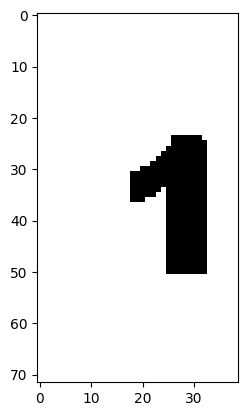

In [189]:
plt.imshow(isolated_leftmost_blacks, cmap="gray")

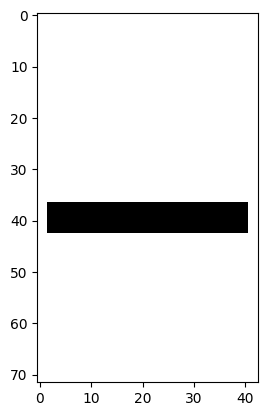

In [190]:
plt.imshow(isolated_rightmost_black, cmap="gray")

In [191]:
# check for presence of black to the left of the rightmost blob to eliminate case of cell value being fixed at a number
has_symbol = img_contains_black(top_half[:, :leftmost_black])

In [192]:
if has_symbol:
    # https://stackoverflow.com/questions/43705481/pytesseract-set-character-whitelist
    string_number = image_to_string(isolated_leftmost_blacks, config="-c tessedit_char_whitelist=0123456789 --psm 7").strip()
    string_symbol = image_to_string(isolated_rightmost_black, config="-c tessedit_char_whitelist=+—x --psm 7").strip()

    # pytesseract fails to recognize ÷ as it was not part of the training data
    string_symbol = '÷' if string_symbol == '' else string_symbol
else:
    string_number = image_to_string(isolated_rightmost_black, config="-c tessedit_char_whitelist=0123456789 --psm 7").strip()
    string_symbol = '='

In [193]:
string_number, string_symbol

('1', '—')

## End experimentation